# Introduction

In search of weirdness, magic and sorcery, this kernel tries some sort of feature engineering based on the supposition that each feature is composed of many features summed with different scales, offsets, etc. 

Here, we assume the data is a composition of many normal distributions and try to create features from this.

This seems a good option either for modeling bumps in features as well as modeling their tendency to form a few hills. 

### Config and load data:

In [8]:
#number of bins in the histogram
slots = 500

#try to model each feature with 8 to 9 normal distributions
#you can adjust this to different ranges
allNorms = range(8,10)

#for keeping this kernel short, model only 5 features/classes
allClasses = range(0,5)

#for early stopping
patience = 10

print('started')





started


In [9]:
import numpy as np, pandas as pd, scipy as sp

%matplotlib inline
from matplotlib import pyplot as plt

import tensorflow as tf
import keras.backend as K
from keras.layers import *
from keras.models import Model
from keras.constraints import NonNeg
from keras.callbacks import EarlyStopping

competitionFolder = '../input/'
trainFile = competitionFolder + 'train.csv'
testFile = competitionFolder + 'test.csv'

nClasses = 200 #max 199
classNames = ['var_' + str(i) for i in range(nClasses)]

def loadData(fileName, targets): 
    frame = pd.read_csv(fileName)
    inputs = frame[classNames].values
    if targets:
        targets = frame['target'].values
        return inputs, targets
    else:
        ids = frame['ID_code'].values
        return inputs, ids

In [10]:
trainData, targets = loadData(trainFile, True)
testData, ids = loadData(testFile, False)
totalData = np.concatenate([trainData, testData], axis=0)

### Keras layer and model to represent a sum of normal distributions

In [11]:
class NormLayer(Layer):
    
    #n = number of normal distributions to model
    
    def __init__(self, n,  **kwargs):
        self.n = n        
        super(NormLayer, self).__init__(**kwargs)
        
        
    #this layer contains 3 groups of weights:
        #- centers (the center of each normal distribution)
        #- scales (will influence the width of the distribution)
        #- amps (the amplitude of each distribution)
    def build(self, inputShape):
        self.centers = [self.add_weight(name='centers'+str(i), shape=(1,), trainable=True, 
                                        initializer='zeros') 
                        for i in range(self.n)]
        
        self.scales = [self.add_weight(name='scales'+str(i), shape=(1,), trainable=True, 
                                       constraint = NonNeg(), initializer='ones') 
                       for i in range(self.n)]
        
        self.amps = [self.add_weight(name='amps'+str(i), shape=(1,), trainable=True, 
                                     constraint = NonNeg(), initializer='ones') 
                     for i in range(self.n)]


    #gets the amplitudes for remodeling the distribution - for test purposes
    def getAmps(self):
        return K.eval(K.concatenate(self.amps))

    
    #this layer returns two results:
        #the actual normal distribution - sums all normal components
        #the indivudial normal distributions without amplitudes - to be used as features
    def call(self, x):
        distribution = K.sum(K.stack([a * K.exp(-K.square(s*(x - c))) 
                              for c,s,a in zip(self.centers, self.scales, self.amps)], 
                             axis=0), axis=0)
        features = K.concatenate([K.exp(-K.square(s*(x - c)))
                       for c,s,a in zip(self.centers, self.scales, self.amps)],
                       axis=-1)
        return [distribution, features]
                             
    
    #keras requirement: the resulting shape of the outputs
    def compute_output_shape(self,inputShape):
        return [inputShape, inputShape[:1] + (self.n,)]
    
    #here you can set the initial parameters of the distributions
    def setParams(self, centers, scales, amps):
        for i in range(self.n):
            K.set_value(self.centers[i], np.array([centers[i]])) 
            K.set_value(self.scales[i], np.array([scales[i]]))
            K.set_value(self.amps[i], np.array([amps[i]]))

#builds a keras model simulating n normal components
def getNormModel(n):
    inp = Input((1,))
    
    #gets the two layer outputs
    outDist, outFeat = NormLayer(n, name='normLayer'+str(n))(inp)
    
    #builds a model to get the resulting distribution - for training
    modelDist = Model(inp,outDist,name='modelDist'+str(n))
    modelDist.compile(optimizer='adam', loss='mse')
    
    #builds a model to get the resulting features - for further use
    modelFeat = Model(inp,outFeat,name='modelFeat'+str(n))

    return modelDist,modelFeat
    
#one model for each number of desired normal distributions
models = {n:getNormModel(n) for n in allNorms}  

### Histogram generating

In [12]:
def getHistogramNeg(dataAllClasses):
    results = list()
    for var in range(nClasses):
        data = dataAllClasses[:,var]
        
        hist, lims = np.histogram(data, bins=slots, density=True)
        x = (lims[:-1] + lims[1:]) / 2. 
        results.append((x, hist))
    return results

   
histogramData = getHistogramNeg(totalData)
print('histogram data len', len(histogramData))


histogram data len 200


### Fitting the distributions and saving features

In [13]:
def fitNormals(xAndHists):
    #params to save if desired
    allParams = list()
    
    #for each class to model
    for i in allClasses:
        x,hist = xAndHists[i] #get respective histogram data
            
        #for deciding the best number of normals
        bestLoss = 1000000
        bestNorms = 0
        
        
        #for each number of normal distributions
        for norms in allNorms:
            modelDist, modelFeat = models[norms]
        
            #initial params for the distributions
            xMin, xMax = x.min(), x.max()
            xMean = (xMin + xMax) / 2.
            divSize = (xMax - xMin) / (norms+1)

            histMax = hist.max() 
            scale = 5 / (xMax - xMin)

            centers = np.array([xMin +(divSize * i) for i in range(1,norms+1)])
            scaleFactors = np.array([(1 + (abs(xMean - c) / divSize)) for c in centers])
            scales = np.array([f*scale for f in scaleFactors])
            amps = np.array([histMax/(f**2) for f in scaleFactors])

            #set initial params in the model
            modelDist.get_layer('normLayer'+str(norms)).setParams(centers, scales, amps)
            
            
            #test code to see the distribution for the initial parameters
            
#             outputs = modelDist.predict_on_batch(x)

#             fig,ax = plt.subplots(ncols=2, figsize=(20,5))
#             fig.suptitle(
#                 'initial and final curve for class '+str(i)+" - norms = "+str(norms)
#             )
#             ax[0].plot(x,hist)
#             ax[0].plot(x,outputs)


            #fitting the model with histogram data
            print('fitting class', i, ' - norms:', norms)
            callbacks = [EarlyStopping(monitor='loss', mode='min',
                                       min_delta=0,patience=patience)]
            history = modelDist.fit(x, hist, batch_size=slots+1,epochs = 1000000, 
                                    callbacks = callbacks, verbose=0)
            loss = history.history['loss'][-patience-1]
            print('loss:', history.history['loss'][-1])
            
            
            #test code to see the final distribution with histogram data
#             ax[1].plot(x,hist)
#             ax[1].plot(x,modelDist.predict(x))
#             plt.show()
            
            #updates which is the best number of distributions
            if loss < bestLoss:
                bestLoss = loss
                bestN = norms
        
        
        #uses the best model for getting params and seeing results
        print('best norms = ', bestN)
        modelDist, modelFeat = models[bestN]
        #modelDist.save_weights('class'+str(i)+"_norms" + str(bestN))
        params = modelDist.get_weights()
        allParams.append((x,params)) 
        
        #for test purposes, predicts with histogram data
        testFeats = modelFeat.predict_on_batch(x)
        amps = modelDist.get_layer('normLayer'+str(bestN)).getAmps()
            #applies the amplitudes to the features and sum
        testDist = (amps.reshape((1,-1))*testFeats).sum(axis=-1) 
        
        #gets model outputs using the original data
        realData = totalData[:,i] #data for a single feature
        realDist = modelDist.predict_on_batch(realData)
        realFeats = modelFeat.predict_on_batch(realData)
        np.save('trainFeats' + str(i) + '.npy', realFeats[:200000])
        np.save('testFeats' + str(i) + '.npy', realFeats[200000:])
        
        
        #visualizing
        print('testFeats shape', testFeats.shape)

        fig,ax = plt.subplots(ncols=2,figsize=(20,5))
        plt.suptitle('feature ' + str(i) + ' - norms: ' + str(bestN))
        
        #plot original histogram data for comparison
        ax[0].plot(x, hist) 
        
        #plot each feature (individual normal distributions - no amps)
        for p in range(bestN):
            ax[0].plot(x, testFeats[:,p])
        ax[1].plot(x, hist) #plots histogram data for comparison
        ax[1].plot(x, testDist) #plots test distribution for comparison 
        
        #sorts the real data and outputs to generate a distribution
        sortedArgs = np.argsort(realData)
        ax[1].plot(realData[sortedArgs], realDist[sortedArgs])
        plt.show()
    
    return allParams

fitting class 0  - norms: 8
loss: 1.5932368114590645e-05
fitting class 0  - norms: 9
loss: 5.618448085442651e-06
best norms =  9
testFeats shape (500, 9)


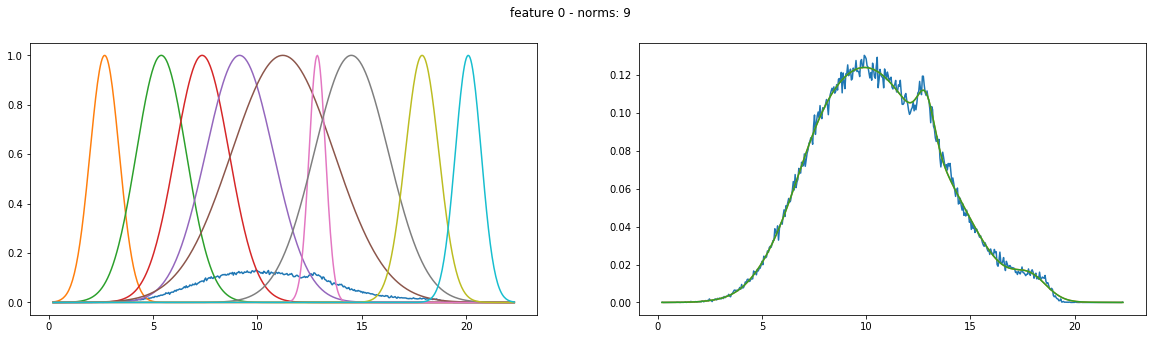

fitting class 1  - norms: 8
loss: 3.389547055121511e-05
fitting class 1  - norms: 9
loss: 3.897951501130592e-06
best norms =  9
testFeats shape (500, 9)


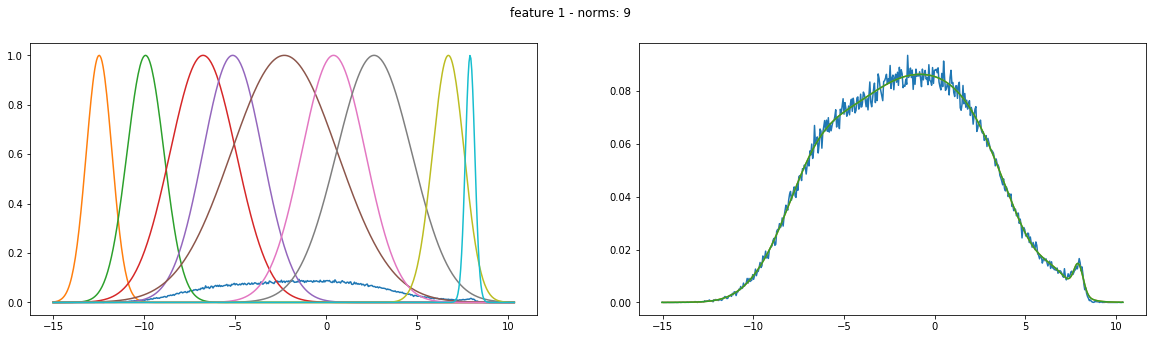

fitting class 2  - norms: 8
loss: 1.072340182872722e-05
fitting class 2  - norms: 9
loss: 9.960736861103214e-06
best norms =  9
testFeats shape (500, 9)


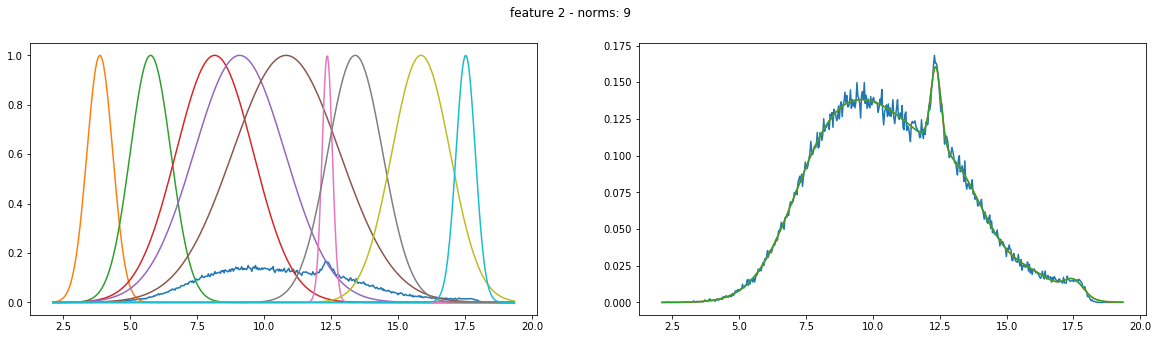

fitting class 3  - norms: 8
loss: 1.2992703886993695e-05
fitting class 3  - norms: 9
loss: 1.2988442904315889e-05
best norms =  9
testFeats shape (500, 9)


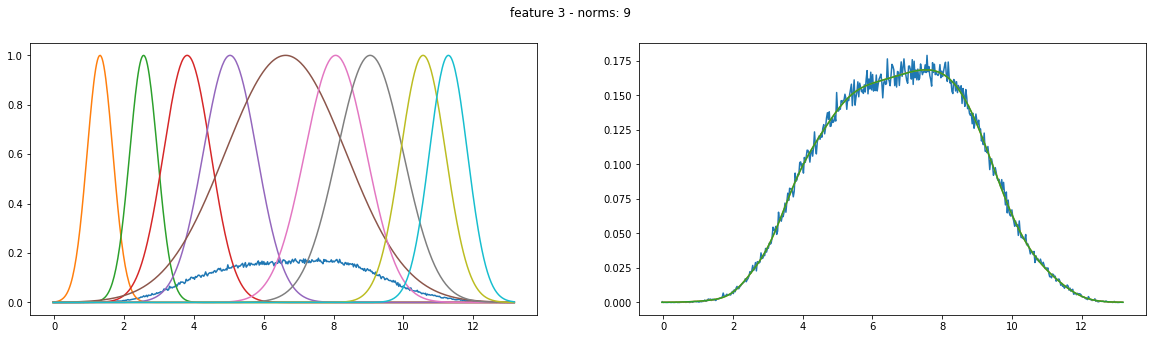

fitting class 4  - norms: 8
loss: 1.53211694851052e-05
fitting class 4  - norms: 9
loss: 1.5296407582354732e-05
best norms =  9
testFeats shape (500, 9)


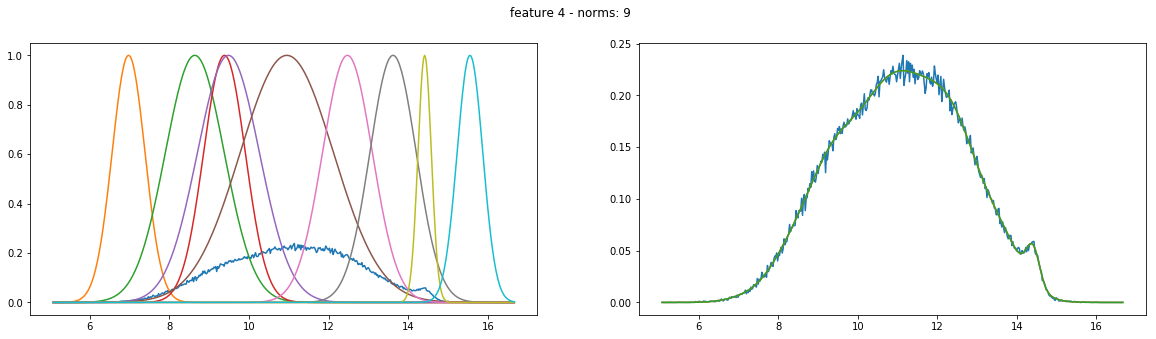

In [14]:
xAndParams = fitNormals(histogramData)        

# Results

Using the generated numpy files as input features in a model can result (so far) in a regular CV score arond 0.89+   
Not sure if selecting the right features from these can bring better results.

This method doesn't quite model the extreme bumps like the ones in var_12 and var_108, but maybe increasing the number of normal distributions?

Finding the right number of distributions could be an interesting question here. Trying from 3 to 16, most features get their best results between 9 and 16 distributions. I'm afraid using too many subdistributions would simply "overfit" the distribution without creating any useful feature.

# Open to ideas :)

If you know any easier or better optimized way of doing this, especially one that allows finding the best/minimum number of distributions, please let me know.

If this helped you, or gave you new ideas, please comment.
And remember I'm in search of a team - not necessarily the campions - to help me find a little magic.